In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import tree
from collections import defaultdict
import random
import pydot
from io import StringIO
import pydotplus

In [34]:
df = pd.read_csv('movie_metadata.csv').dropna()
df = df.sample(frac=1).reset_index(drop=True)

In [35]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [36]:
dataset = df[['gross', 'imdb_score', 'movie_title']]
print(len(dataset))
dataset = dataset.values.tolist()

3756


In [37]:
def kMedoids(data, k, prev_cost, count, clusters=None, medoids=None):

    cluster_sum = 0
    random.seed(0)

    while True:

        if medoids is None or not medoids:
            medoids = random.sample(data, k)
        else:
            random.shuffle(medoids)
            for _ in range(0, int(k/2)):
                medoids.pop()
            medoids += random.sample(data, int(k/2))

        clusters = defaultdict(list)

        for item in data:
            temp = []
            for i in range(0, len(medoids)):
                med = medoids[i]
                if med is None or not med:
                    break
                else:
                    temp.append(np.linalg.norm(
                        med[0]-item[0])+np.linalg.norm(med[1]-item[1]))
            min_index = np.argmin(temp)
            clusters[min_index].append(item)

        for i in range(0, len(medoids)):
            inter_cluster = clusters[i]
            for j in range(0, len(inter_cluster)):
                item_cluster = inter_cluster[j]
                medoid = medoids[i]
                cluster_sum += (np.linalg.norm(medoid[0]-item_cluster[0]) +
                                np.linalg.norm(medoid[1]-item_cluster[1]))

        if cluster_sum < prev_cost:
            prev_cost = cluster_sum
        else:
            break

        count += 1

    return clusters

In [38]:
clusters = kMedoids(dataset, 5, np.inf, 0)
for i in range(0,len(clusters)):
    print(str(i+1),len(clusters.get(i)))

1 625
2 298
3 256
4 812
5 1765


No handles with labels found to put in legend.


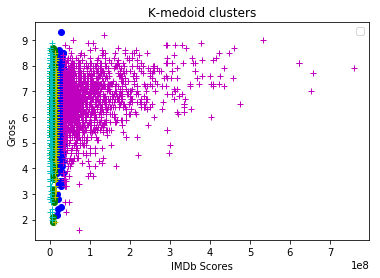

In [39]:
def plot_graph(clusters):
    markers = ['bo', 'go', 'y+', 'c+', 'm+', 'ro']
    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            plt.plot(df[0], df[1], markers[i])
    plt.xlabel('IMDb Scores')
    plt.ylabel('Gross')
    plt.title('K-medoid clusters')
    plt.legend()
    plt.show()

plot_graph(clusters)

In [40]:
columns = ['num_user_for_reviews', 'budget'
               , 'num_critic_for_reviews', 'movie_title','movie_facebook_likes','num_voted_users','duration']

df = df[columns]

In [41]:
def assign_target(row, clusters):

    x = row['movie_title']

    for i in range(0, len(clusters.keys())):
        data = clusters.get(i)
        for j in range(0, len(data)):
            df = data[j]
            if df[2] == x:
                row['cluster'] = 'cluster'+str(i)

    return row

In [42]:
df = df.reset_index()
df = df.apply(assign_target, args=(clusters,), axis=1)
df.drop(labels = ['movie_title'], axis = 1, inplace = True)
print(df.tail())

      index  num_user_for_reviews       budget  num_critic_for_reviews  \
3751   3751                 297.0  100000000.0                   141.0   
3752   3752                 210.0   40000000.0                   292.0   
3753   3753                  79.0   16000000.0                    46.0   
3754   3754                 463.0   11000000.0                   161.0   
3755   3755                 188.0   12000000.0                   132.0   

      movie_facebook_likes  num_voted_users  duration   cluster  
3751                     0           128285      78.0  cluster4  
3752                 19000           126307     123.0  cluster1  
3753                     0             3662      85.0  cluster3  
3754                  5000            59982     100.0  cluster2  
3755                     0            20000     122.0  cluster1  


In [43]:
df_before_split = df.copy()
print(df.head())
splitSet = StratifiedShuffleSplit(
        n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in splitSet.split(df, df['cluster']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

Y_train = train_set.cluster
X_train = train_set[train_set.columns.drop('cluster').drop('index')]
Y_test = test_set.cluster
X_test = test_set[test_set.columns.drop('cluster').drop('index')]

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

predictions = decision_tree.predict(X_test)

   index  num_user_for_reviews       budget  num_critic_for_reviews  \
0      0                1732.0   40000000.0                   374.0   
1      1                 239.0   35000000.0                    95.0   
2      2                  69.0  120000000.0                    71.0   
3      3                 316.0   19000000.0                   251.0   
4      4                 124.0    2600000.0                   173.0   

   movie_facebook_likes  num_voted_users  duration   cluster  
0                 13000           656640     147.0  cluster4  
1                     0            48621     112.0  cluster0  
2                   459            36471      77.0  cluster4  
3                  5000           132149     141.0  cluster2  
4                     0            40878      66.0  cluster3  


In [44]:
print('Accuracy', decision_tree.score(X_test, Y_test))

Accuracy 0.5279255319148937


In [45]:
print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[ 37  11   7  15  55]
 [ 13   7   6  23  11]
 [ 11  13   7  10  10]
 [ 19  15  13 100  16]
 [ 54  14  15  24 246]]


             precision    recall  f1-score   support

   cluster0       0.28      0.30      0.29       125
   cluster1       0.12      0.12      0.12        60
   cluster2       0.15      0.14      0.14        51
   cluster3       0.58      0.61      0.60       163
   cluster4       0.73      0.70      0.71       353

avg / total       0.53      0.53      0.53       752



In [46]:
rfc = RandomForestClassifier(n_estimators=2000)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(Y_test,rfc_pred))
print('\n')
print(classification_report(Y_test,rfc_pred))

[[ 22   2   4  21  76]
 [  7   5   5  26  17]
 [ 15   5   4  11  16]
 [ 17   3   2 121  20]
 [ 31   1   1  14 306]]


             precision    recall  f1-score   support

   cluster0       0.24      0.18      0.20       125
   cluster1       0.31      0.08      0.13        60
   cluster2       0.25      0.08      0.12        51
   cluster3       0.63      0.74      0.68       163
   cluster4       0.70      0.87      0.78       353

avg / total       0.55      0.61      0.56       752



In [ ]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, impurity=False, feature_names=train_set.columns.drop('cluster').drop('index'))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("dtree.png")